# Анализ собранных данных

В рамках исследования были собраны публикации пользователей из социальной сети ВКонтакте.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

Подготовка данных для анализа:

In [2]:
# todo: Добавить облака слов до и после удаления стоп слов
stop_words = set(stopwords.words('russian'))

def clean_text(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
with open("dataset/data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

users = []
posts = []

for user in data:
    user_id = user["user_id"]
    user_info = {
        "user_id": user_id,
        "sex": user["sex"],
        "city": user["city"],
        "followers_count": user["followers_count"],
        "alcohol": user["alcohol"],
        "smoking": user["smoking"],
        "life_main": user["life_main"],
        "people_main": user["people_main"],
        "status": user["status"],
        "label": user["label"],
    }
    users.append(user_info)
    for post in user["posts"]:
        posts.append({
            "user_id": user_id,
            "text": clean_text(post["text"]),
            "date": post["date"],
            "likes": post["likes"],
            "comments": post["comments"],
            "reposts": post["reposts"],
            "views": post["views"],
            "word_count": len(post["text"].split())
        })

df_users = pd.DataFrame(users)
df_posts = pd.DataFrame(posts)

Итоговый набор включает:

In [4]:
num_users = df_users["user_id"].nunique()
num_posts = len(df_posts)
post_fields = list(df_posts.columns)
user_fields = list(df_users.columns)
label_counts = df_users["label"].value_counts().to_dict()
num_depressive = label_counts.get(1, 0)
num_neutral = label_counts.get(0, 0)

print(f"Количество пользователей: {num_users}")
print(f"Количество постов: {num_posts}")
print(f"Количество депрессивных пользователей: {num_depressive}")
print(f"Количество нейтральных пользователей: {num_neutral}")
print(f"Поля поста: {post_fields}")
print(f"Поля пользователя: {user_fields}")

Количество пользователей: 85914
Количество постов: 206805
Количество депрессивных пользователей: 1327
Количество нейтральных пользователей: 84587
Поля поста: ['user_id', 'text', 'date', 'likes', 'comments', 'reposts', 'views', 'word_count']
Поля пользователя: ['user_id', 'sex', 'city', 'followers_count', 'alcohol', 'smoking', 'life_main', 'people_main', 'status', 'label']


## Визуализация данных

#### Распределение количества слов в постах:

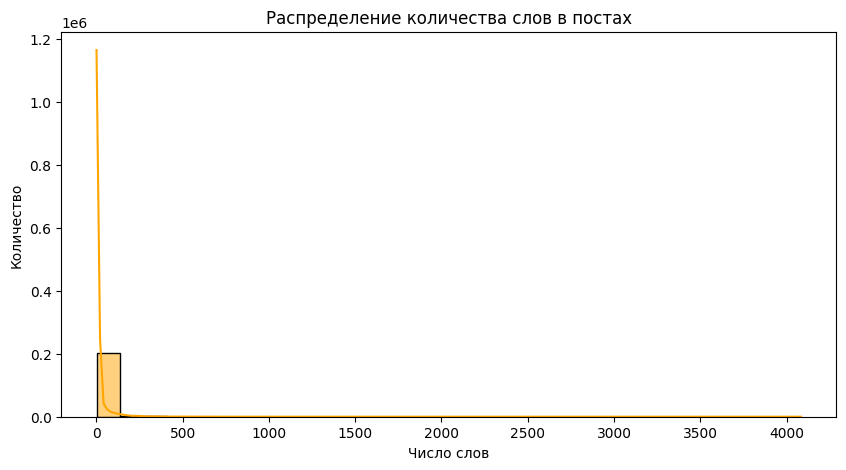

In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(df_posts["word_count"], bins=30, kde=True, color="orange")
plt.title("Распределение количества слов в постах")
plt.xlabel("Число слов")
plt.ylabel("Количество")
plt.show()

На представленном графике отображено распределение числа слов в публикациях пользователей. Видно, что большинство постов укладываются в диапазон до 100 слов, при этом распределение скошено вправо, указывая на наличие выбросов — более длинных публикаций. Это типично для социальных сетей, где большинство сообщений краткие, но иногда встречаются эмоционально насыщенные длинные тексты.

#### Средняя длина постов:

In [6]:
avg_words = df_posts["word_count"].mean()
print(f"Средняя длина поста: {avg_words:.2f} слов")

Средняя длина поста: 18.83 слов


#### Топ-10 городов по числу пользователей:

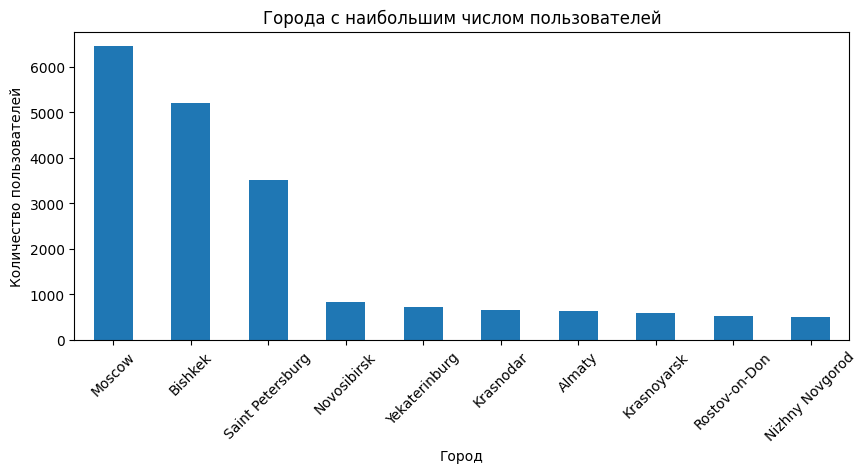

In [7]:
plt.figure(figsize=(10, 4))
df_users["city"].value_counts().head(10).plot(kind="bar")
plt.title("Города с наибольшим числом пользователей")
plt.xlabel("Город")
plt.ylabel("Количество пользователей")
plt.xticks(rotation=45)
plt.show()

Гистограмма отображает десять наиболее представленных городов среди собранных пользователей. Лидирующую позицию занимает Санкт-Петербург, что логично с учётом открытости профилей и активности пользователей из крупных городов. Анализ географического распределения может быть полезен для оценки региональных особенностей лексики и эмоциональной экспрессии.

#### Распределение длины постов по классам:

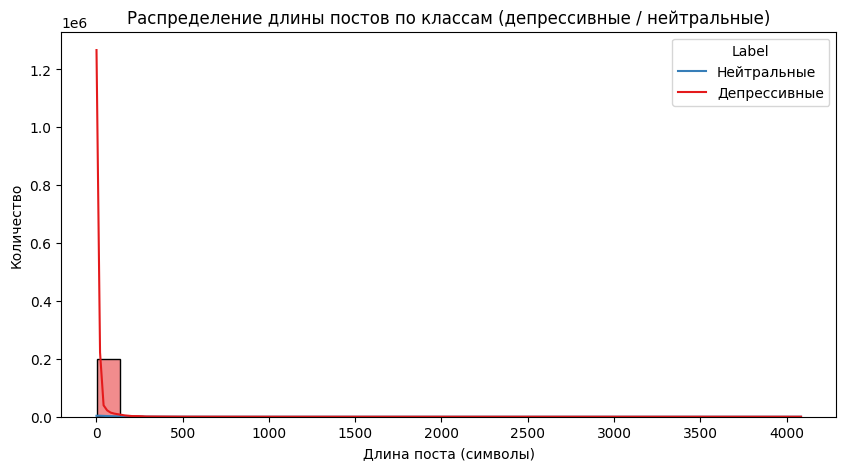

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_posts.merge(df_users[["user_id", "label"]], on="user_id"),
             x="word_count", hue="label", bins=30, kde=True, palette="Set1")
plt.title("Распределение длины постов по классам (депрессивные / нейтральные)")
plt.xlabel("Длина поста (символы)")
plt.ylabel("Количество")
plt.legend(title="Label", labels=["Нейтральные", "Депрессивные"])
plt.show()

Данный график иллюстрирует сравнение распределения количества слов в постах в зависимости от принадлежности пользователя к депрессивной или нейтральной группе. Можно заметить, что посты пользователей с признаками депрессии имеют тенденцию быть более длинными, с более выраженной правой «хвостовой» частью распределения, что может отражать повышенную эмоциональную экспрессию и вербальную детализацию.

#### Распределения пользователей по различным признакам профиля

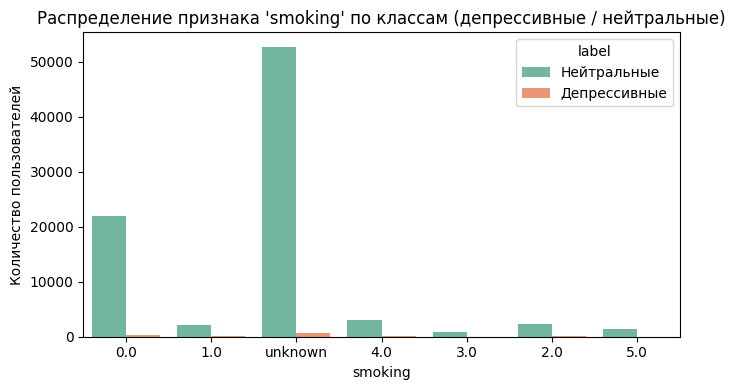

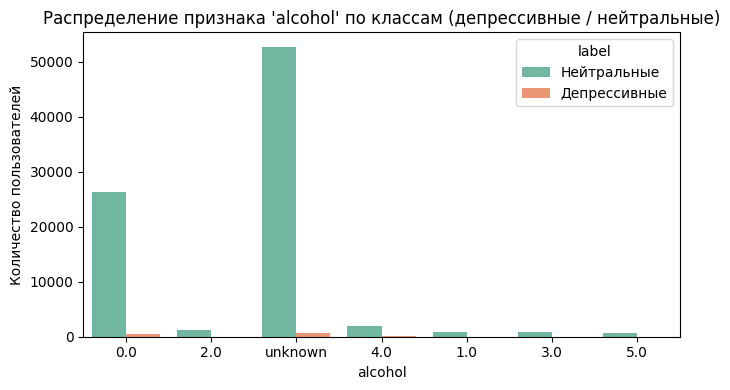

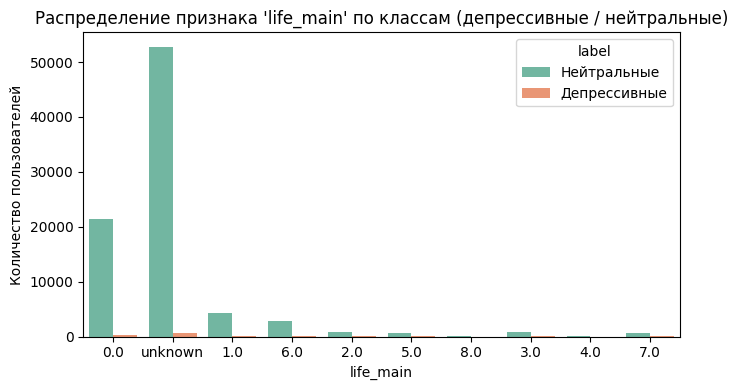

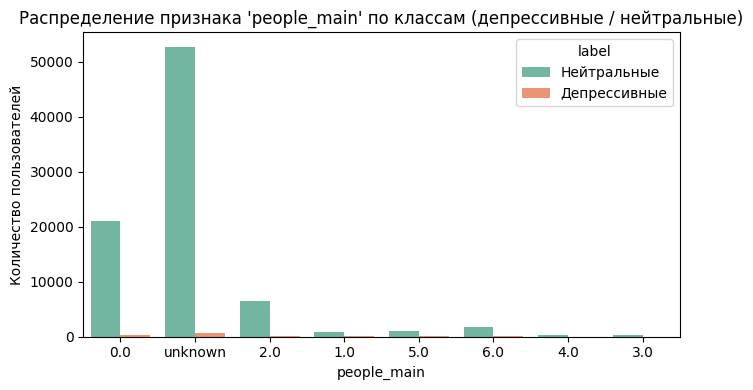

In [9]:
cat_features = ["smoking", "alcohol", "life_main", "people_main"]

df_vis = df_users.copy()
for col in cat_features:
    df_vis[col] = df_vis[col].fillna("unknown")

for col in cat_features:
    if df_vis[col].nunique() > 1:
        plt.figure(figsize=(7, 4))
        sns.countplot(data=df_vis, x=col, hue="label", palette="Set2")
        plt.title(f"Распределение признака '{col}' по классам (депрессивные / нейтральные)")
        plt.xlabel(col)
        plt.ylabel("Количество пользователей")
        plt.legend(title="label", labels=["Нейтральные", "Депрессивные"])
        plt.tight_layout()
        plt.show()

Видно сильный перевес, из за дисбаланса класса, нужно построить еще раз после балансировки.

#### Boxplot длины постов по классам:

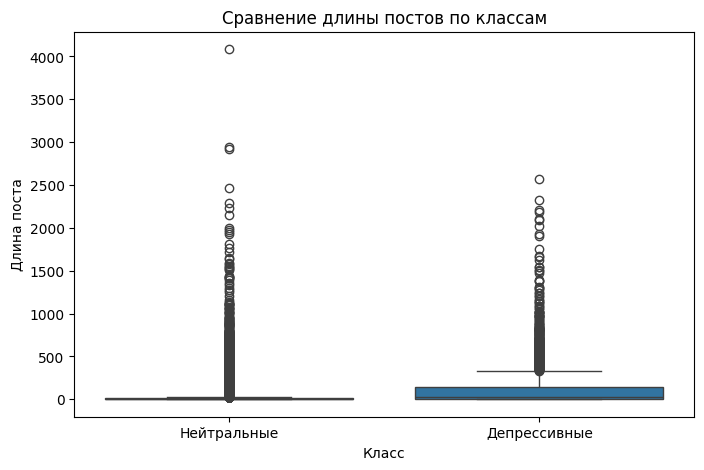

In [10]:
merged = df_posts.merge(df_users[["user_id", "label"]], on="user_id")
plt.figure(figsize=(8, 5))
sns.boxplot(x="label", y="word_count", data=merged)
plt.xticks([0, 1], ["Нейтральные", "Депрессивные"])
plt.title("Сравнение длины постов по классам")
plt.xlabel("Класс")
plt.ylabel("Длина поста")
plt.show()

Boxplot-график позволяет сравнить медианные значения и разброс количества слов в постах между двумя классами пользователей. Видно, что у депрессивной группы медиана выше, как и межквартильный размах, что подтверждает гипотезу о более развёрнутом изложении мыслей у данной категории пользователей. Также наблюдаются выбросы — крайне длинные публикации, характерные для пользователей с высоким уровнем вовлечённости или эмоциональной нагрузки.

#### Boxplot длины постов по метке депрессивности:

Text(0.5, 1.0, 'Сравнение длины постов по классам')

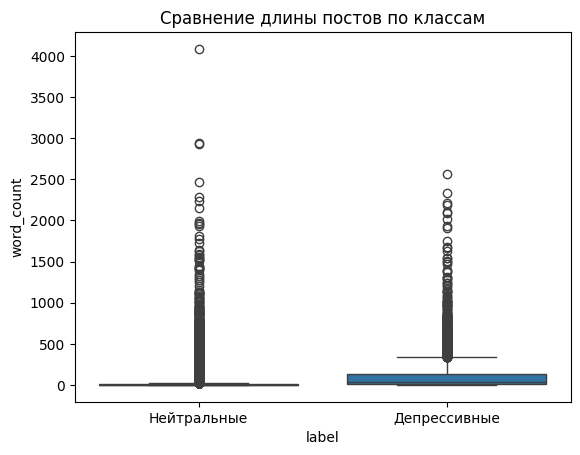

In [11]:
merged = df_posts.merge(df_users[["user_id", "label"]], on="user_id")
sns.boxplot(x="label", y="word_count", data=merged)
plt.xticks([0, 1], ["Нейтральные", "Депрессивные"])
plt.title("Сравнение длины постов по классам")


Средняя длина постов (депрессивные): 115.52 слов
Средняя длина постов (нейтральные): 16.77 слов


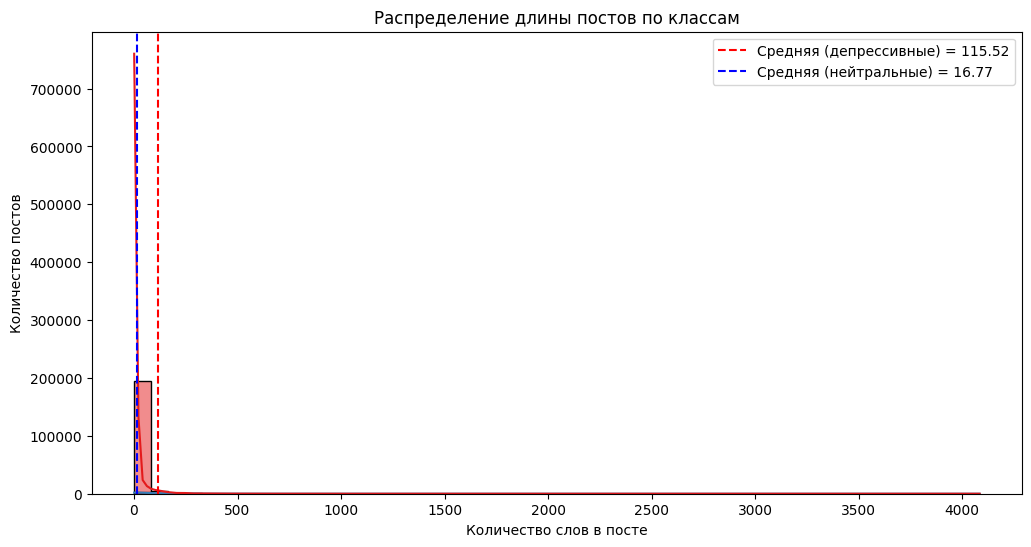

In [16]:
# Анализ средней длины постов по классам
plt.figure(figsize=(12, 6))

# Расчет средней длины постов по классам
avg_length_depressive = df_posts[df_posts['user_id'].isin(df_users[df_users['label'] == 1]['user_id'])]['word_count'].mean()
avg_length_neutral = df_posts[df_posts['user_id'].isin(df_users[df_users['label'] == 0]['user_id'])]['word_count'].mean()

print(f"Средняя длина постов (депрессивные): {avg_length_depressive:.2f} слов")
print(f"Средняя длина постов (нейтральные): {avg_length_neutral:.2f} слов")

# Визуализация распределения длины постов по классам
sns.histplot(data=df_posts.merge(df_users[['user_id', 'label']], on='user_id'),
             x="word_count", hue="label", bins=50, kde=True, palette="Set1")
plt.axvline(avg_length_depressive, color='red', linestyle='--', label=f'Средняя (депрессивные) = {avg_length_depressive:.2f}')
plt.axvline(avg_length_neutral, color='blue', linestyle='--', label=f'Средняя (нейтральные) = {avg_length_neutral:.2f}')
plt.title("Распределение длины постов по классам")
plt.xlabel("Количество слов в посте")
plt.ylabel("Количество постов")
plt.legend()
plt.show()

#### Частотность публикаций по метке:

Text(0.5, 1.0, 'Распределение количества постов по метке')

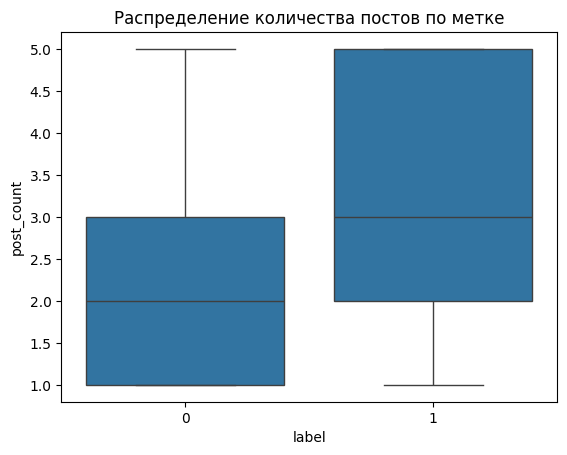

In [12]:
post_counts = df_posts.groupby("user_id").size().reset_index(name="post_count")
df_merged = df_users.merge(post_counts, on="user_id")
sns.boxplot(x="label", y="post_count", data=df_merged)
plt.title("Распределение количества постов по метке")


Этот график технически дублирует предыдущий, но если он отличается по оформлению или метрике (например, text_length вместо word_count), его можно сохранить. В противном случае — рекомендуется удалить или переместить в Приложение.

#### Распределение реакций (лайки, просмотры и пр.):

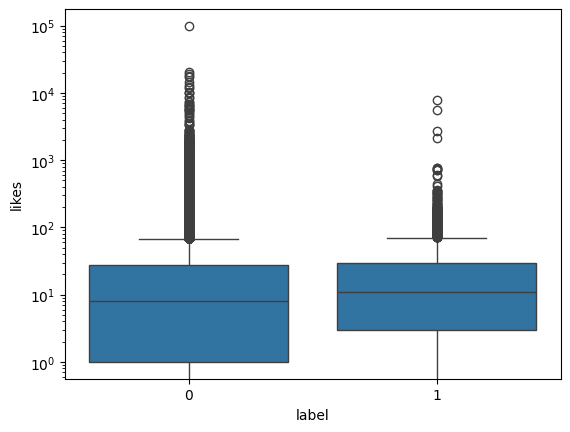

In [13]:
sns.boxplot(x="label", y="likes", data=merged)
plt.yscale("log")  # если есть выбросы


График демонстрирует различие в вовлечённости пользователей (по числу лайков) между нейтральной и депрессивной группами. Использование логарифмической шкалы обусловлено наличием выбросов — единичных постов с аномально высоким числом реакций. В среднем, посты обеих групп получают сопоставимое количество лайков, однако разброс в депрессивной группе может быть шире, что говорит о нестабильной реакции аудитории на эмоционально окрашенные публикации.

#### WordCloud по классам (для текста):

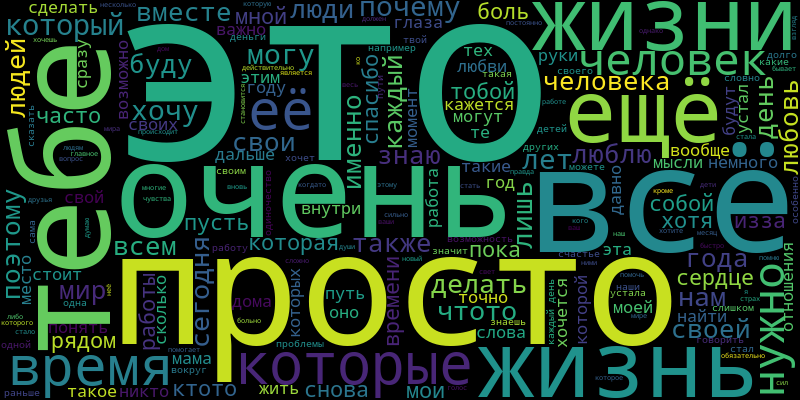

In [14]:
text_dep = " ".join(merged[merged["label"] == 1]["text"])
WordCloud(width=800, height=400).generate(text_dep).to_image()

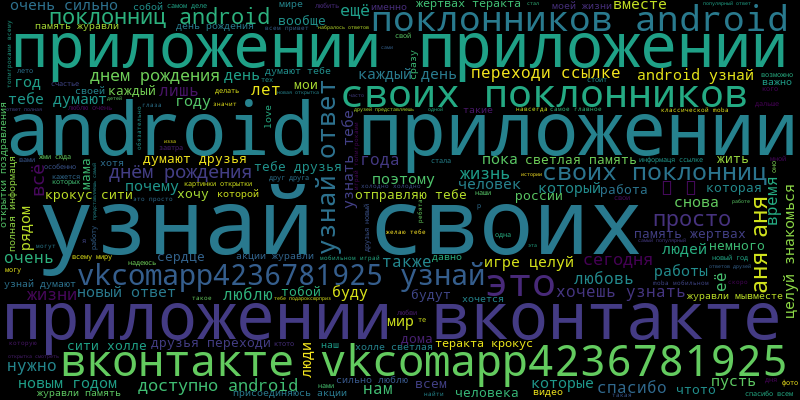

In [15]:
text_neu = " ".join(merged[merged["label"] == 0]["text"])
WordCloud(width=800, height=400).generate(text_neu).to_image()

Облако слов формируется на основе частоты использования слов в текстах пользователей. Визуализация наглядно демонстрирует лексические различия между депрессивными и нейтральными группами. В текстах депрессивных пользователей чаще встречаются слова с негативной семантикой — «пустота», «боль», «одиночество», тогда как нейтральные публикации наполнены более повседневной лексикой. WordCloud предоставляет быстрый интуитивный способ визуального анализа доминирующих тем и эмоционального фона.

На облаке слов, сформированном по текстам пользователей с меткой label = 1, заметно преобладание лексем с негативной семантикой, таких как «одиночество», «пустота», «не вижу смысла», «усталость». Это подтверждает гипотезу о наличии тематических и эмоциональных особенностей, характерных для депрессивного контекста.

В то же время облако слов для нейтральных пользователей включает более разнообразную и повседневную лексику, часто связанную с позитивными событиями, профессиональной деятельностью или общением.